
Metrics:
Stock: AAPL | RMSE:  28.3395 MAE:  23.5818  MAPE:  13.2636  Accuracy:  50.1006


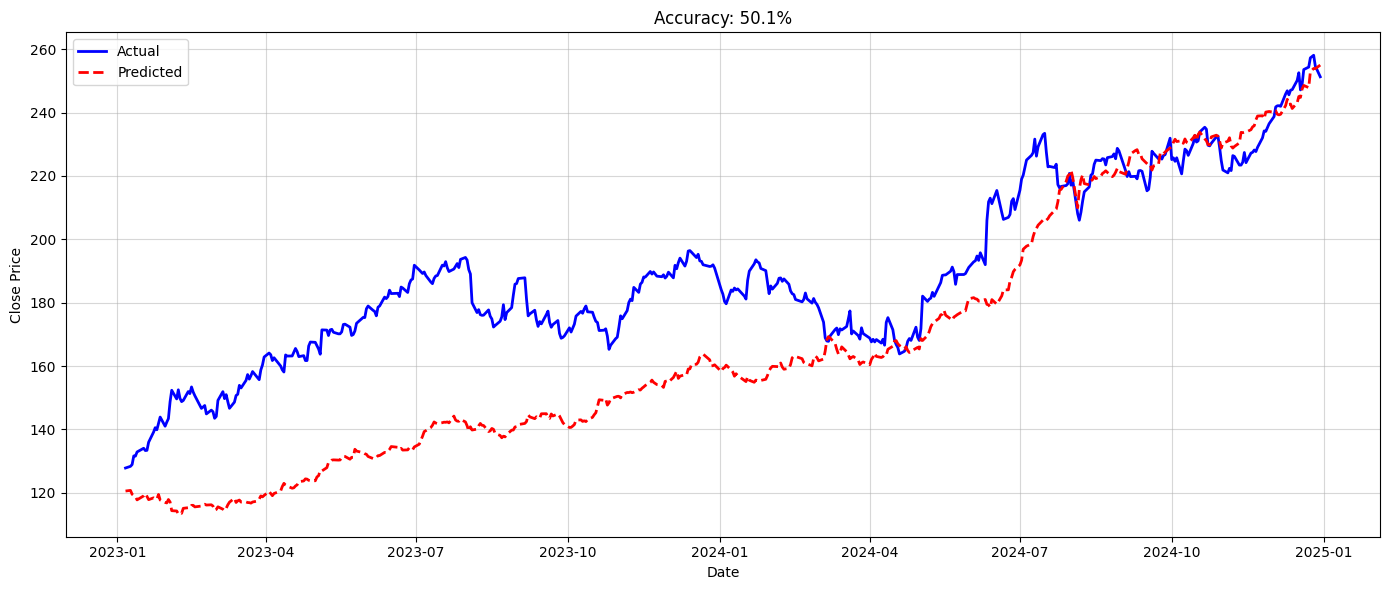

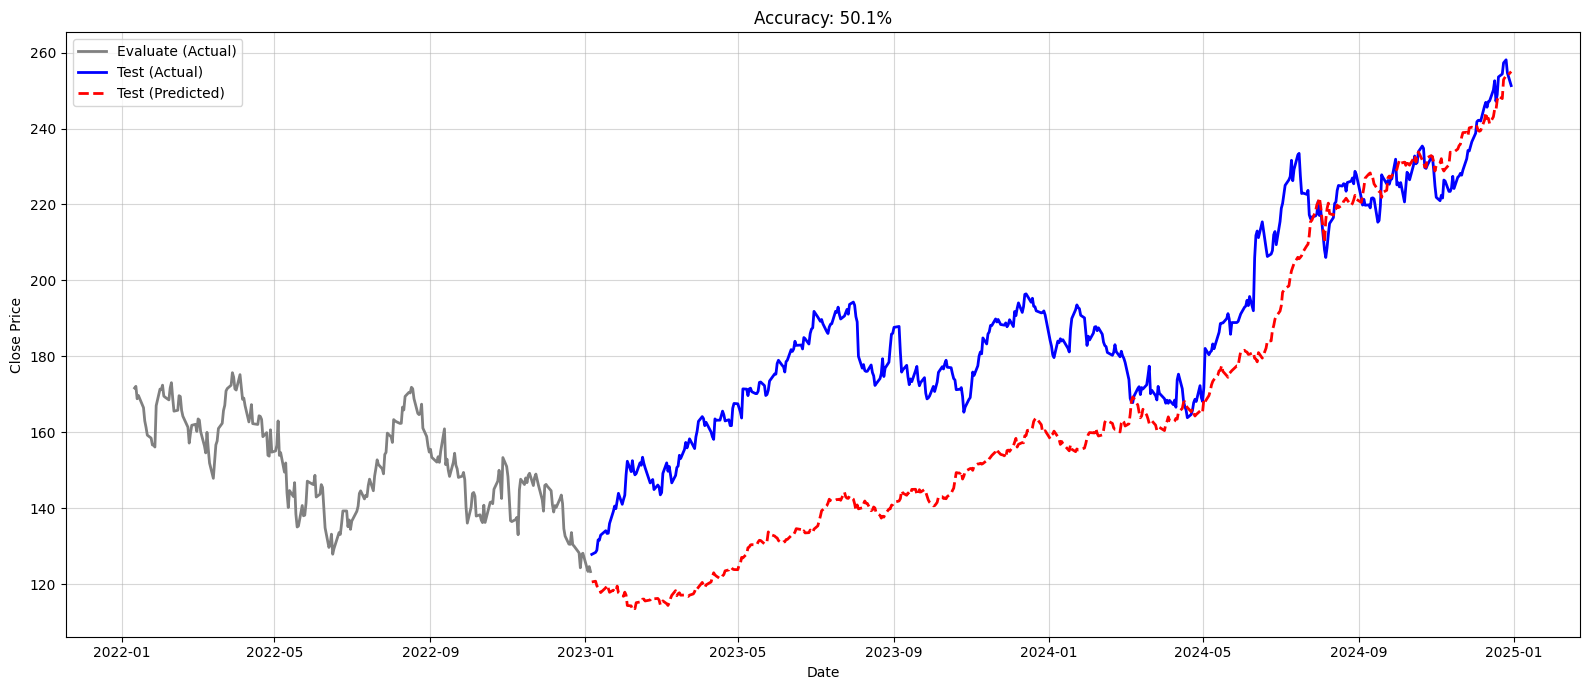

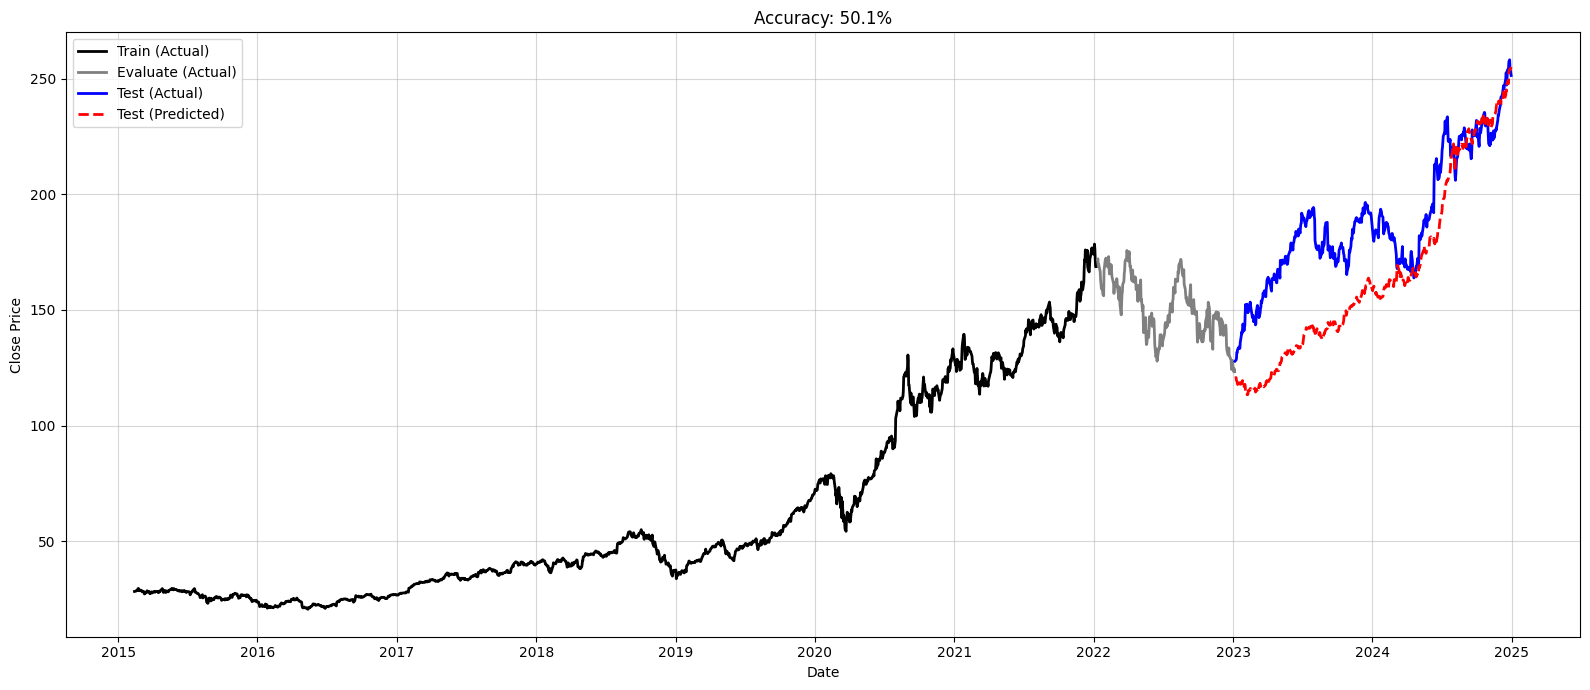

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv("AAPL_processed_20251115_161521.csv", index_col=0, parse_dates=True)
data = data.dropna().copy()

feature_cols = ['High_Low_Ratio','Open_Close_Ratio','Close_to_Open','High_Low_Range','Return_lag1','Return_lag2','Return_lag3',
                'Volume_Change','Volume_lag1','Distance_from_MA_20', 'Volatility']
X = data[feature_cols]
y = data['Next_Return']

split_0_to_80 = int(len(X) * 0.7)
split_0_to_10= int(len(X)* 0.1)

X_train, y_train = X.iloc[:split_0_to_80], y.iloc[:split_0_to_80]
X_evaluate, y_evaluate =X.iloc[split_0_to_80: split_0_to_80 + split_0_to_10], y.iloc[split_0_to_80: split_0_to_80 + split_0_to_10]
X_test, y_test = X.iloc[split_0_to_80 + split_0_to_10:], y.iloc[split_0_to_80 + split_0_to_10:]

# Train
xgb = XGBRegressor(n_estimators=1000,max_depth=5, subsample=0.8, colsample_bytree=0.8,random_state=42,learning_rate=0.05)
#Fit
xgb.fit(X_train, y_train, eval_set=[(X_evaluate, y_evaluate)], verbose=False)
#Predict
y_predictions = xgb.predict(X_test)

# Calculating prediction prices for metrics
predicted_price_temp = []
last_price = data['Close'].iloc[(split_0_to_80 + split_0_to_10) - 1] # Collects the $ of the 79.9%th data

for pred_return in y_predictions:
    next_price = last_price * (1 + pred_return / 100)
    last_price = next_price
    predicted_price_temp.append(next_price)
    

predicted_prices = np.array(predicted_price_temp)
actual_prices = data['Close'].loc[X_test.index].values

# Metrics
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mae = mean_absolute_error(actual_prices, predicted_prices)
mape = 100 * np.mean(np.abs((actual_prices - predicted_prices) / actual_prices))

# Accuracy 
actual_direction = np.sign(np.diff(actual_prices))
pred_direction = np.sign(np.diff(predicted_prices))
accuracy = 100 * np.mean(actual_direction == pred_direction)

print(f"\nMetrics:")
print("Stock: AAPL | RMSE: ", "%.4f" %rmse, "MAE: ", "%.4f" %mae, " MAPE: ", "%.4f" %mape, " Accuracy: ", "%.4f" %accuracy)

# Plot 
plt.figure(figsize=(14, 6))
plt.plot(X_test.index, actual_prices, label='Actual', linewidth=2, color='blue')
plt.plot(X_test.index, predicted_prices, label='Predicted', linewidth=2, linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title(f'Accuracy: {accuracy:.1f}%')
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()


train_prices = data['Close'].iloc[:split_0_to_80]
eval_prices  = data['Close'].iloc[split_0_to_80: split_0_to_80 + split_0_to_10]
test_prices  = data['Close'].iloc[split_0_to_80 + split_0_to_10:]

# Plot 2
plt.figure(figsize=(16, 7))
plt.plot(eval_prices.index, eval_prices.values, 
         label='Evaluate (Actual)', linewidth=2, color='gray')
plt.plot(test_prices.index, actual_prices, 
         label='Test (Actual)', linewidth=2, color='blue')
plt.plot(test_prices.index, predicted_prices, 
         label='Test (Predicted)', linewidth=2, linestyle='--', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title(f'Accuracy: {accuracy:.1f}%')
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

# Plot 3
plt.figure(figsize=(16, 7))
plt.plot(train_prices.index, train_prices.values, 
         label='Train (Actual)', linewidth=2, color='black')
plt.plot(eval_prices.index, eval_prices.values, 
         label='Evaluate (Actual)', linewidth=2, color='gray')
plt.plot(test_prices.index, actual_prices, 
         label='Test (Actual)', linewidth=2, color='blue')
plt.plot(test_prices.index, predicted_prices, 
         label='Test (Predicted)', linewidth=2, linestyle='--', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title(f'Accuracy: {accuracy:.1f}%')
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

